# Test for distortions in the FFIs

Find CCD positions [here](https://tess.mit.edu/observations/).

First, start with a single CCD in camera 1 (the one closest to the ecliptic) in sector 1.  Do your calculations for 4 different positions within that CCD, and see if the magnitude and direction of the offset is the same in each case.  Then do that again for a different CCD in the camera 1.  Is there any difference?  Is everything off by the same direction and magnitude?  Then do this again for CCDs in Camera 4.

## Conclusions

- `lightkurve` and `eleanor` do use the same coordinate axes; if you tell them to look at the same position, they will do so.

In [41]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import os
from math import *

SECTOR = 1
CAMERA = 1
CCD = 1

POSTCARD_SIZE = 30
FFI_SIZE = 180
FFI_SIZE_DEGREES = 1

CAMERA_FOV = 24
SQRT_CCDS_PER_CAMERA = 2

LIGHTKURVE_CACHE = "/home/jtdinsmo/.lightkurve-cache/tesscut/"

cameraCenters = {1:{1:(324.57, -33.17, 289.92), 2:(338.58, -55.08, 299.88), 3:(19.49, -71.98, 157.19), 4:(90.00, -66.56, 224.19)}}
    # Units are (RA, dec, roll).

In [42]:
coords = [cameraCenters[SECTOR][CAMERA][0] - CAMERA_FOV / 2, cameraCenters[SECTOR][CAMERA][1] - CAMERA_FOV / 2]
    # lower left coord of camera
row = CCD // SQRT_CCDS_PER_CAMERA
col = CCD % SQRT_CCDS_PER_CAMERA;
coords[0] += col * CAMERA_FOV / SQRT_CCDS_PER_CAMERA + CAMERA_FOV / SQRT_CCDS_PER_CAMERA / 2
coords[1] += row * CAMERA_FOV / SQRT_CCDS_PER_CAMERA + CAMERA_FOV / SQRT_CCDS_PER_CAMERA / 2
    # now coords represent the middle of the CCD.

In [43]:
OFFSET = 4 # Number of degrees to move my ffi from the CCD center
targetCoords = [(coords[0] - OFFSET, coords[1] - OFFSET),
             (coords[0] - OFFSET, coords[1] + OFFSET),
             (coords[0] + OFFSET, coords[1] - OFFSET),
             (coords[0] + OFFSET, coords[1] + OFFSET)]

ffiOffsets = [(-0.4, -0.4), (-0.4, -0.4), (-0.4, -0.4), (-0.4, -0.4)]

In [44]:
def downloadSmall(c):
    foundLocal = False
    for file in os.listdir(LIGHTKURVE_CACHE):
        if file.endswith("{0}x{0}_astrocut.fits".format(POSTCARD_SIZE)): # Confirm size
            if c[0] == float(file.split("_")[-4]): # Confirm RA
                if c[1] == float(file.split("_")[-3]): # Confirm dec
                    tpf = lk.TessTargetPixelFile(LIGHTKURVE_CACHE + file)
                    foundLocal = True
                    break
    if not foundLocal:
        search = lk.search_tesscut(str(c[0]) + ' ' + str(c[1]))
        char = ""
        if len(search) != 1: char = "s"
        print("{0} has {1} result{2}.".format(c, len(search), char))
        tpf = search[0].download(cutout_size=POSTCARD_SIZE)

    return tpf[tpf.flux.shape[0] // 2].flux.reshape((POSTCARD_SIZE, POSTCARD_SIZE))

In [45]:
def downloadLarge(c):
    foundLocal = False
    for file in os.listdir(LIGHTKURVE_CACHE):
        if file.endswith("{0}x{0}_astrocut.fits".format(FFI_SIZE)): # Confirm size
            if c[0] == float(file.split("_")[-4]): # Confirm RA
                if c[1] == float(file.split("_")[-3]): # Confirm dec
                    tpf = lk.TessTargetPixelFile(LIGHTKURVE_CACHE + file)
                    foundLocal = True
                    break
    if not foundLocal:
        search = lk.search_tesscut(str(c[0]) + ' ' + str(c[1]))
        char = ""
        if len(search) != 1: char = "s"
        print("{0} has {1} result{2}.".format(c, len(search), char))
        tpf = search[0].download(cutout_size=FFI_SIZE)
        print("Download complete")

    return tpf[tpf.flux.shape[0] // 2].flux.reshape((FFI_SIZE, FFI_SIZE))

In [46]:
### This function is flawed. I will fix it.

def dot(u, v):
    return sum([u[i] * v[i] for i in range(len(u))])

def sub(u, v):
    return [u[i] - v[i] for i in range(len(u))]

def mul(u, s):
    if(type(u) != list):
        return [s[i] * u for i in range(len(s))]
    return [u[i] * s for i in range(len(u))]
    

def mag(v):
    return sqrt(dot(v, v))

def globalToImageCoords(ra, dec, centerRA, centerDec):
    ra = ra * pi / 180
    dec = dec * pi / 180
    centerRA = centerRA * pi / 180
    centerDec = centerDec * pi / 180
    
    target = [cos(ra) * cos(dec), sin(ra) * cos(dec), sin(dec)]
    imageCenter = [cos(centerRA) * cos(centerDec), sin(centerRA) * cos(centerDec), sin(centerDec)]
    target = mul(target, 1/dot(target, imageCenter))
    
    disp = sub(target, imageCenter)
    north = [-cos(centerRA) * sin(centerDec), -sin(centerRA) * sin(centerDec), cos(centerDec)]
    east = [sin(centerRA), -cos(centerRA), 0]
    angle = acos(dot(disp, north) / mag(north) / mag(disp))# Angle from north, measured towards east.
    if(dot(disp, east) < 0):
        angle = 2 * pi - angle
    
    length = acos(min(1, dot(target, imageCenter) / mag(imageCenter) / mag(target))) * 180 / pi# radians
    return [-int(length * FFI_SIZE / FFI_SIZE_DEGREES * sin(angle)) + FFI_SIZE // 2,
            int(length * FFI_SIZE / FFI_SIZE_DEGREES * cos(angle)) + FFI_SIZE // 2]

(326.17, -35.57) has 1 result.
Download complete
(334.17, -43.57) has 1 result.


HTTPError: The TESS FFI cutout service at MAST appears to be temporarily unavailable. It returned the following error: 504 Server Error: Gateway Time-out for url: https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=334.17&dec=-43.57&y=180&x=180&units=px&sector=1

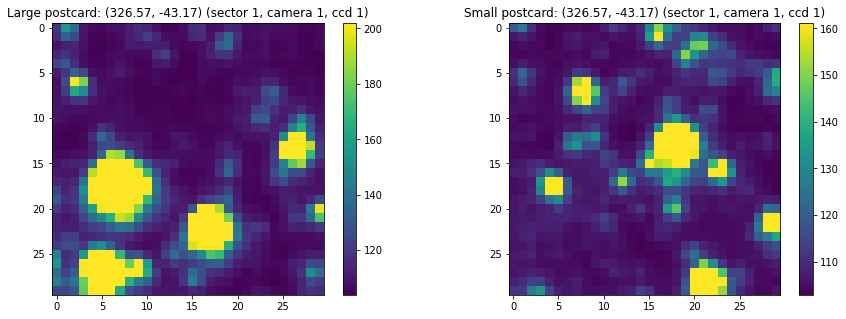

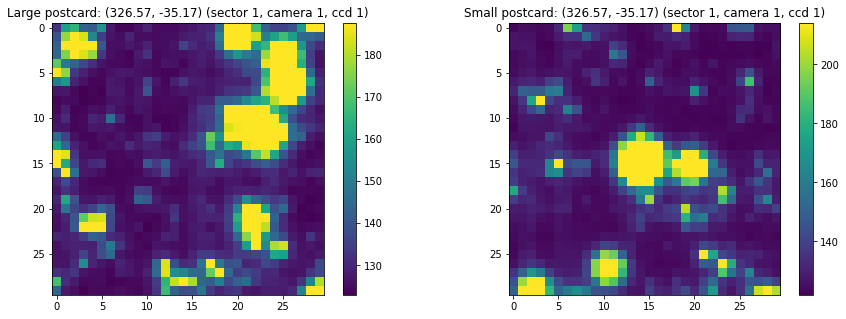

In [48]:
for i in range(len(targetCoords)):
    ffiCenter = (targetCoords[i][0] + ffiOffsets[i][0],targetCoords[i][1] + ffiOffsets[i][1])
    large = downloadLarge(ffiCenter)
    small = downloadSmall(targetCoords[i])
    
    cutoutCenter = globalToImageCoords(targetCoords[i][0], targetCoords[i][1], ffiCenter[0], ffiCenter[1])
    cutoutRect = [cutoutCenter[0] - POSTCARD_SIZE // 2, cutoutCenter[1] - POSTCARD_SIZE // 2, 
                  cutoutCenter[0] + POSTCARD_SIZE // 2, cutoutCenter[1] + POSTCARD_SIZE // 2]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
    
    a = ax1.imshow(large[cutoutRect[1]:cutoutRect[3],cutoutRect[0]:cutoutRect[2]], vmax = np.nanpercentile(large, 95));
    plt.colorbar(a, ax=ax1);
    ax1.set_title("Large postcard: {0} (sector {1}, camera {2}, ccd {3})".format(targetCoords[i], SECTOR, CAMERA, CCD))
    
    b = ax2.imshow(small, vmax = np.nanpercentile(small, 95))
    plt.colorbar(b, ax=ax2);
    ax2.set_title("Small postcard: {0} (sector {1}, camera {2}, ccd {3})".format(targetCoords[i], SECTOR, CAMERA, CCD))